##### Imports

In [1]:
import sys
from pathlib import Path
import warnings

import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

import sys
# Custom library paths
sys.path.extend(['../', './scr'])

from scr.utils import set_seed
from scr.utils import read_words
from pathlib import Path
import random
from collections import Counter, defaultdict
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset

from scr.utils import read_words, save_words_to_file

import pickle
from pathlib import Path
from scr.dataset import *
from scr.utils import *
# # For inference
from scr.feature_engineering import *
from scr.encoder import *
from scr.trainer_ import *
from scr.decoder import SimpleLSTM

import gc

set_seed(42)

import torch
import torch.nn as nn
from pathlib import Path
import random

from scr.utils import print_scenarios
torch.set_float32_matmul_precision('medium')
from pathlib import Path

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Read and Shuffle Word List
word_list = read_words('data/words_250000_train.txt') # , limit=10000)
# word_list = read_words('data/250k.txt', limit=10000)

random.shuffle(word_list)

# Calculate Frequencies and Max Word Length
word_frequencies = calculate_word_frequencies(word_list)
char_frequency = calculate_char_frequencies(word_list)
max_word_length = max(len(word) for word in word_list)

##### Data Dir

In [2]:
NUM_STRATIFIED_SAMPLES = 100 # This will be overwritten by Papermill

NUM_WORD_SAMPLE = 1_000 # words for testing

FAST_DEV_RUN = False

MAX_EPOCH = 250

In [3]:
from pathlib import Path
from scr.custom_sampler import *

# Define the base directory and the paths for training and validation parquet files
base_dataset_dir = Path("/media/sayem/510B93E12554BBD1/dataset/")
stratified_samples_dir = base_dataset_dir / str(NUM_STRATIFIED_SAMPLES)
parquet_path = stratified_samples_dir / 'parquets'

# Create directories for train and validation parquets if they don't exist
parquet_path.mkdir(parents=True, exist_ok=True)
# parquet_valid_path.mkdir(parents=True, exist_ok=True)

# Define and create the directory for models
models_dir = Path("/home/sayem/Desktop/Hangman/models")
models_dir.mkdir(parents=True, exist_ok=True)

# Define your output directory
# Define your output directory and logger directory
output_dir = Path("/home/sayem/Desktop/Hangman/training_outputs")
logger_dir = output_dir / "lightning_logs"

# Create the output and logger directories if they don't exist
output_dir.mkdir(parents=True, exist_ok=True)
logger_dir.mkdir(parents=True, exist_ok=True)

# Define the file path for saving the testing words
testing_words_file_path = stratified_samples_dir / "testing_words.txt"

try:
    testing_word_list = read_words(testing_words_file_path)
    print(f"Length of the testing word list: {len(testing_word_list)}")
    sampled_test_words = stratified_sample_by_length_and_uniqueness(testing_word_list, NUM_WORD_SAMPLE)
    print(f"Sampled {len(sampled_test_words)} unique words for testing.")
except FileNotFoundError:
    print(f"File not found: {testing_words_file_path}")

print(len(sampled_test_words))

Length of the testing word list: 10048
Sampled 1085 unique words for testing.
1085


##### Dataset Loading and train test split

In [4]:
# Create datasets directly from the saved parquet files
hangman_dataset = HangmanDataset(parquet_path)
# valid_dataset = HangmanDataset(parquet_valid_path)

from scr.utils import *

# Split the dataset into training and validation sets
train_dataset, valid_dataset = hangman_dataset.split(test_size=0.2)

In [5]:
def check_seq_len_distribution(dataset):
    distribution = {}
    for seq_len, indices in dataset.seq_len_index.items():
        distribution[seq_len] = len(indices)
    return distribution

def check_seq_len_distribution(dataset):
    distribution = {}
    for seq_len, indices in dataset.seq_len_index.items():
        distribution[seq_len] = len(indices)
    return distribution

# Check proportions
print(f"Total samples in original dataset: {len(hangman_dataset)}")
print(f"Samples in training dataset: {len(train_dataset)}")
print(f"Samples in validation dataset: {len(valid_dataset)}")

# Verify that the sum of train and validation samples equals the total samples
assert len(train_dataset) + len(valid_dataset) == len(hangman_dataset), "Mismatch in total sample count"

# Check sequence length distribution in each dataset
train_distribution = check_seq_len_distribution(train_dataset)
valid_distribution = check_seq_len_distribution(valid_dataset)

print("Training dataset sequence length distribution:", train_distribution)
print("Validation dataset sequence length distribution:", valid_distribution)

# Ensure each sequence length is represented in both datasets
assert set(train_distribution.keys()) == set(valid_distribution.keys()), "Mismatch in sequence length representation"

Total samples in original dataset: 8658
Samples in training dataset: 6916
Samples in validation dataset: 1742
Training dataset sequence length distribution: {4: 456, 5: 412, 7: 936, 6: 344, 9: 666, 8: 852, 3: 597, 2: 1092, 11: 327, 14: 116, 10: 445, 12: 264, 18: 32, 17: 49, 15: 88, 16: 59, 13: 156, 19: 13, 20: 11, 21: 1}
Validation dataset sequence length distribution: {4: 115, 5: 104, 7: 234, 6: 87, 9: 167, 8: 213, 3: 150, 2: 274, 11: 82, 14: 30, 10: 112, 12: 67, 18: 9, 17: 13, 15: 23, 16: 15, 13: 39, 19: 4, 20: 3, 21: 1}


In [6]:
def count_unique_seq_lens(dataset):
    # Count the unique sequence lengths in the dataset
    unique_seq_lens = len(dataset.seq_len_index)
    return unique_seq_lens

train_unique_seq_lens = count_unique_seq_lens(train_dataset)
valid_unique_seq_lens = count_unique_seq_lens(valid_dataset)

print(f"Unique sequence lengths in training dataset: {train_unique_seq_lens}")
print(f"Unique sequence lengths in validation dataset: {valid_unique_seq_lens}")

Unique sequence lengths in training dataset: 20
Unique sequence lengths in validation dataset: 20


##### Model Initialization

In [7]:
# Fixed parameters
max_word_length = 29  # Maximum word length
num_embeddings = 28   # Vocabulary size (fixed, based on unique characters in the game)
num_features = 159     # Number of features per character
missed_char_dim = 28  # Additional dimension for missed characters
output_dim = 28       # Output dimension for the model
char_feature_dim = 5  # Features per character
additional_state_features = num_features \
    - max_word_length * char_feature_dim   # Additional features per state


# Tunable hyperparameters
LEARNING_RATE = 0.0009279463391755308
HIDDEN_DIM = 32 ### 32
NUM_LAYERS = 1
EMBEDDING_DIM = 50
DROPOUT_PROB = 0.33

L1_FACTOR = 0.0005236754641745983
L2_FACTOR = 0.004375162823431166

OPTIMIZER = 'RMSprop'

print(f"Addition state fetatures: {additional_state_features}")
# Initialize the Encoder

encoder = Encoder(num_embeddings, EMBEDDING_DIM, max_word_length, \
    char_feature_dim, additional_state_features)

input_dim = max_word_length * EMBEDDING_DIM + additional_state_features
# Initialize the SimpleLSTM decoder
decoder = SimpleLSTM(input_dim=input_dim, 
                     hidden_dim=HIDDEN_DIM, 
                     output_dim=output_dim, 
                     num_layers=NUM_LAYERS,
                     missed_char_dim=missed_char_dim,
                     dropout_prob=DROPOUT_PROB)


# Initialize the HangmanModel
lightning_model = HangmanModel(encoder, decoder, 
                LEARNING_RATE, char_frequency, 
                max_word_length, optimizer_type=OPTIMIZER, \
                l1_factor=L1_FACTOR,
                l2_factor=L2_FACTOR, test_words=sampled_test_words)

# Save the model's state dictionary
untrained_model_file = models_dir / f"{NUM_STRATIFIED_SAMPLES}_untrained_model.pth"
torch.save(lightning_model, untrained_model_file)
print(f"Model saved at {untrained_model_file}")

Addition state fetatures: 14
Model saved at /home/sayem/Desktop/Hangman/models/100_untrained_model.pth


##### Data Module

In [8]:
from scr.data_module import *

# Initialize Data Module
initial_batch_size = 128 # Set your initial batch size

# Initialize Data Module with the required arguments
data_module = HangmanDataModule(train_dataset, valid_dataset, 
                                initial_batch_size, 
                                custom_collate_fn)
                                # performance_metrics=None)

##### Tuning the Model

In [9]:
## callbacks
from pytorch_lightning.callbacks import Callback, EarlyStopping
from scr.custom_callbacks import *

# Setup EarlyStopping to monitor the test_win_rate
early_stop_callback = EarlyStopping(
    monitor='win_rate',
    min_delta=0.00,
    patience=10,
    verbose=True,
    mode='max'  # Maximize the win rate
)

step_level_early_stopping = StepLevelEarlyStopping(
    monitor='val_miss_penalty', # Metric to monitor
    min_delta=0.0,              # Minimum change to qualify as an improvement
    patience=5                  # Number of steps with no improvement after which training will be stopped
)

[I 2024-02-01 17:12:49,183] A new study created in memory with name: NUM_STRATIFIED_SAMPLES_100_HangmanModelTuning


Starting trial with parameters:
  Learning Rate: 0.04684192711305397
  Batch Size: 512
  Hidden Dim: 128
  Num Layers: 5
  Embedding Dim: 50
  Optimizer Type: SGD
  Dropout Prob: 0.259479225369076
  L1 Factor: 0.00011063194927799195
  L2 Factor: 0.006891452280454699


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoder    | 1.4 K 
1 | decoder | SimpleLSTM | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.945    Total estimated model params size (MB)


Standard batching activated...
Standard batching activated...
Standard batching activated...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved. New best score: 1.659


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_0_2024-02-01_17-13-06.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_1_2024-02-01_17-13-24.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_2_2024-02-01_17-13-41.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_3_2024-02-01_17-13-58.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_4_2024-02-01_17-14-16.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_5_2024-02-01_17-14-33.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.092 >= min_delta = 0.0. New best score: 1.751


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_6_2024-02-01_17-14-52.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_7_2024-02-01_17-15-11.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_8_2024-02-01_17-15-33.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.369 >= min_delta = 0.0. New best score: 2.120


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_9_2024-02-01_17-15-53.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.184 >= min_delta = 0.0. New best score: 2.304


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_10_2024-02-01_17-16-14.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_11_2024-02-01_17-16-33.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.184 >= min_delta = 0.0. New best score: 2.488


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_12_2024-02-01_17-16-54.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.461 >= min_delta = 0.0. New best score: 2.949


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_13_2024-02-01_17-17-16.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.369 >= min_delta = 0.0. New best score: 3.318


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_14_2024-02-01_17-17-35.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.184 >= min_delta = 0.0. New best score: 3.502


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_15_2024-02-01_17-17-55.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.092 >= min_delta = 0.0. New best score: 3.594


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_16_2024-02-01_17-18-18.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 1.014 >= min_delta = 0.0. New best score: 4.608


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_17_2024-02-01_17-18-37.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.461 >= min_delta = 0.0. New best score: 5.069


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_18_2024-02-01_17-18-59.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.645 >= min_delta = 0.0. New best score: 5.714


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_19_2024-02-01_17-19-21.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 1.198 >= min_delta = 0.0. New best score: 6.912


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_20_2024-02-01_17-19-42.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 1.382 >= min_delta = 0.0. New best score: 8.295


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_21_2024-02-01_17-20-04.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 1.382 >= min_delta = 0.0. New best score: 9.677


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_22_2024-02-01_17-20-25.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.553 >= min_delta = 0.0. New best score: 10.230


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_23_2024-02-01_17-20-47.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 1.106 >= min_delta = 0.0. New best score: 11.336


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_24_2024-02-01_17-21-09.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 1.843 >= min_delta = 0.0. New best score: 13.180


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_25_2024-02-01_17-21-31.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 2.120 >= min_delta = 0.0. New best score: 15.300


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_26_2024-02-01_17-21-54.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.184 >= min_delta = 0.0. New best score: 15.484


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_27_2024-02-01_17-22-15.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.092 >= min_delta = 0.0. New best score: 15.576


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_28_2024-02-01_17-22-38.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.092 >= min_delta = 0.0. New best score: 15.668


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_29_2024-02-01_17-22-59.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Metric win_rate improved by 0.092 >= min_delta = 0.0. New best score: 15.760


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_30_2024-02-01_17-23-21.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_31_2024-02-01_17-23-40.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_32_2024-02-01_17-23-59.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_33_2024-02-01_17-24-18.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_34_2024-02-01_17-24-37.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_35_2024-02-01_17-24-59.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_36_2024-02-01_17-25-21.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_37_2024-02-01_17-25-43.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_38_2024-02-01_17-26-04.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_39_2024-02-01_17-26-26.png
Performance batch sampler activated...


Validation: |          | 0/? [00:00<?, ?it/s]

Processing words:   0%|          | 0/1085 [00:00<?, ?word/s]

Monitored metric win_rate did not improve in the last 10 records. Best score: 15.760. Signaling Trainer to stop.
[I 2024-02-01 17:26:48,008] Trial 0 finished with value: 15.760368347167969 and parameters: {'learning_rate': 0.04684192711305397, 'batch_size': 512, 'hidden_dim': 128, 'num_layers': 5, 'embedding_dim': 50, 'optimizer_type': 'SGD', 'dropout_prob': 0.259479225369076, 'l1_factor': 0.00011063194927799195, 'l2_factor': 0.006891452280454699}. Best is trial 0 with value: 15.760368347167969.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Plot saved to /home/sayem/Desktop/Hangman/plots/win_rates_plot_epoch_40_2024-02-01_17-26-47.png
Trial 0 finished with value: 15.760368347167969 and parameters: {'learning_rate': 0.04684192711305397, 'batch_size': 512, 'hidden_dim': 128, 'num_layers': 5, 'embedding_dim': 50, 'optimizer_type': 'SGD', 'dropout_prob': 0.259479225369076, 'l1_factor': 0.00011063194927799195, 'l2_factor': 0.006891452280454699}.
 Best trial so far: Trial 0
 Best win rate so far: 15.760368347167969
Starting trial with parameters:
  Learning Rate: 0.035424418694337476
  Batch Size: 128
  Hidden Dim: 32
  Num Layers: 5
  Embedding Dim: 30
  Optimizer Type: SGD
  Dropout Prob: 0.3773227560134002
  L1 Factor: 0.00020116267303513807
  L2 Factor: 0.0013501394643013675


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[W 2024-02-01 17:26:48,023] Trial 1 failed with parameters: {'learning_rate': 0.035424418694337476, 'batch_size': 128, 'hidden_dim': 32, 'num_layers': 5, 'embedding_dim': 30, 'optimizer_type': 'SGD', 'dropout_prob': 0.3773227560134002, 'l1_factor': 0.00020116267303513807, 'l2_factor': 0.0013501394643013675} because of the following error: TypeError("unsupported operand type(s) for //: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/sayem/anaconda3/envs/optiver/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_270639/2388250106.py", line 92, in objective
    trainer.fit(model, datamodule=data_module)
  File "/home/sayem/anaconda3/envs/optiver/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 545, in fit
    call._call_and_handle_interrupt(
  File "/home/sayem/anaconda3/envs/optiver/lib/python3.10/site-packages/p

Performance batch sampler activated...
Performance batch sampler activated...


TypeError: unsupported operand type(s) for //: 'int' and 'NoneType'

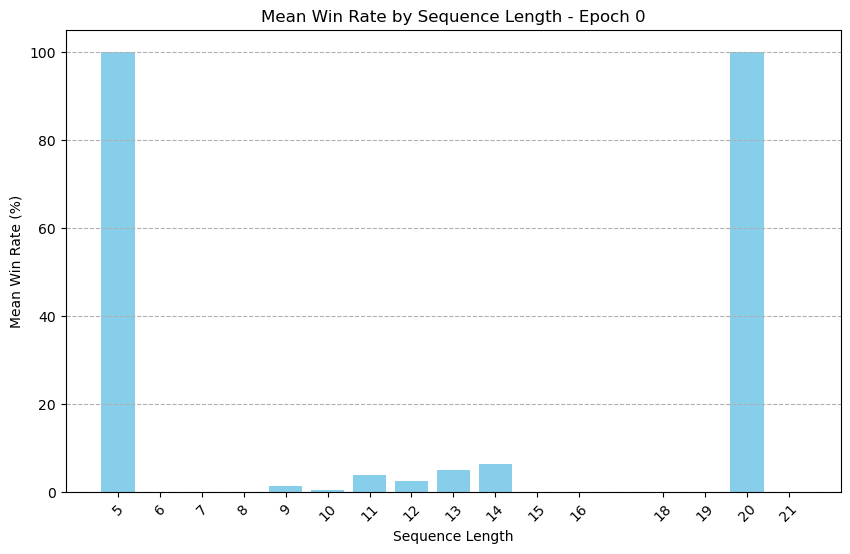

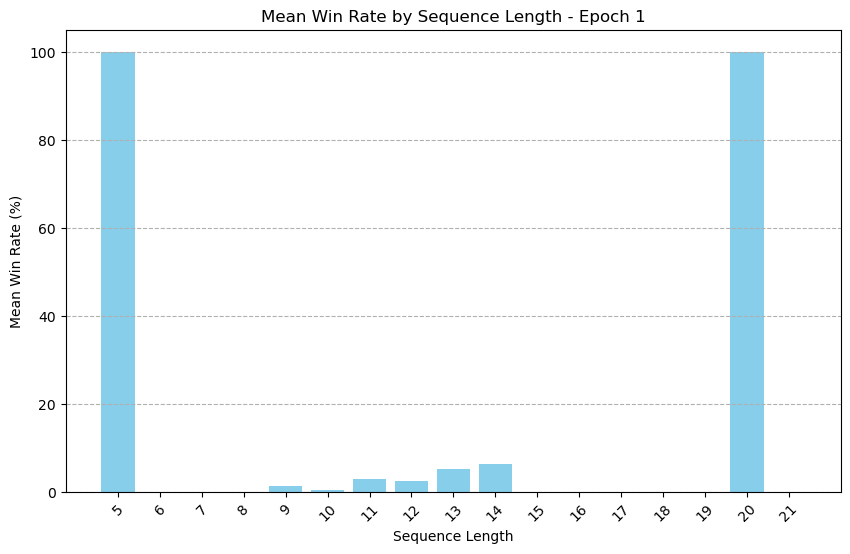

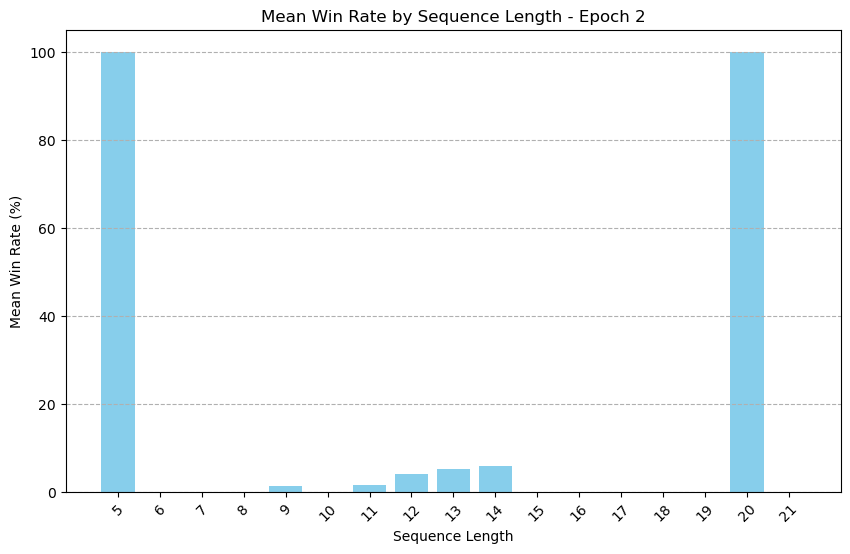

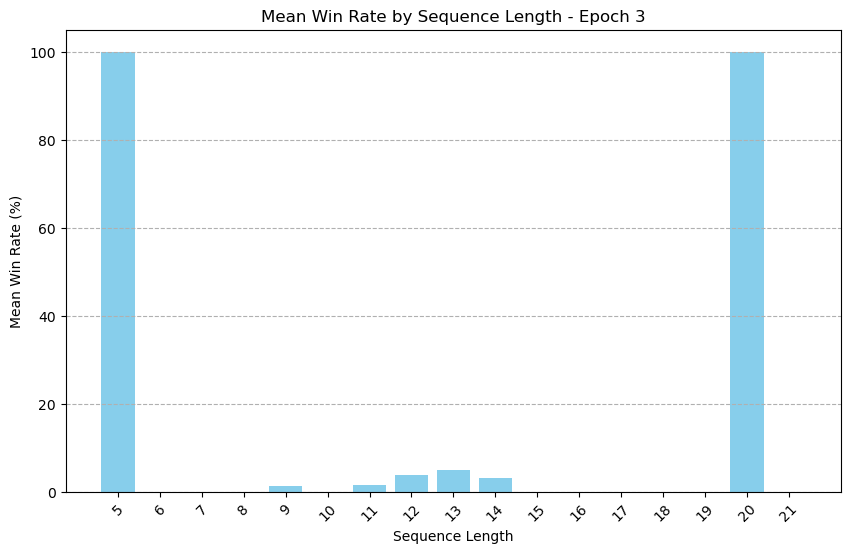

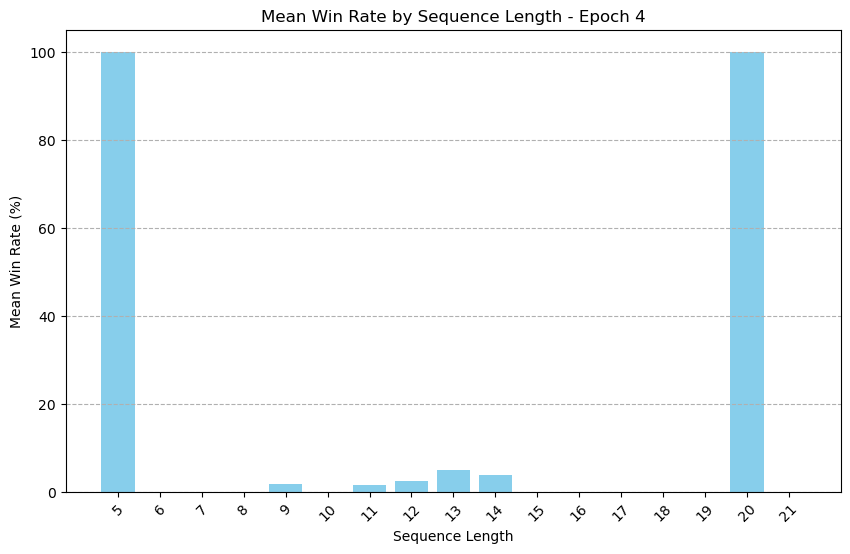

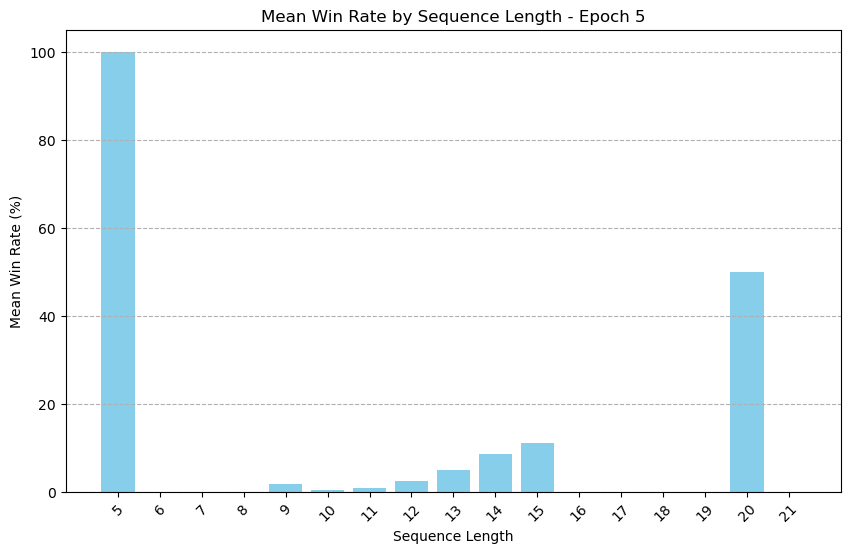

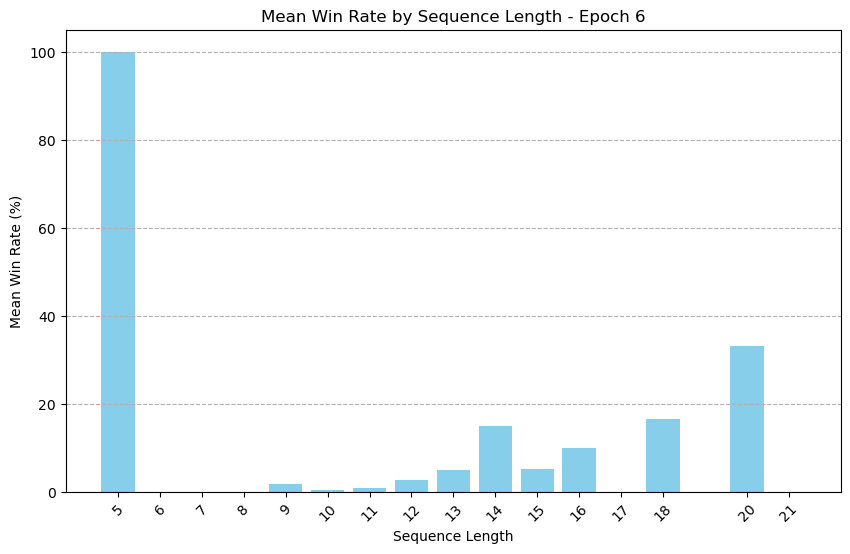

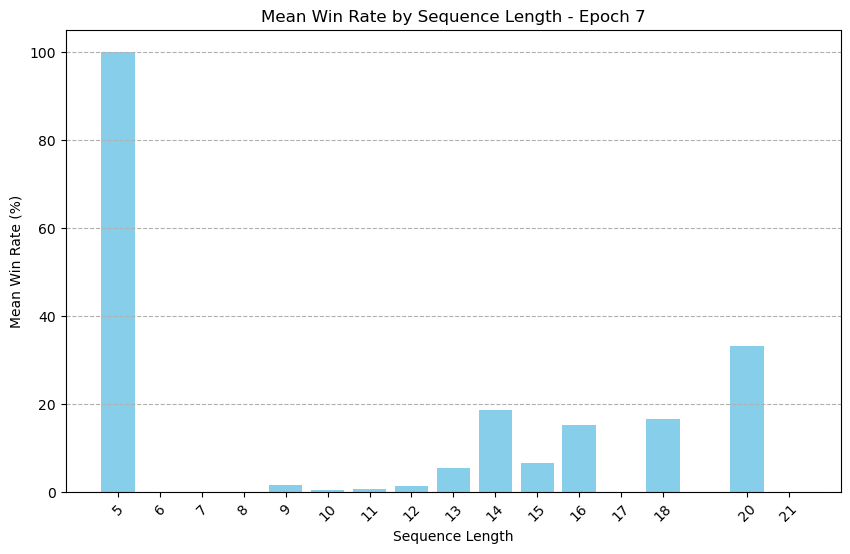

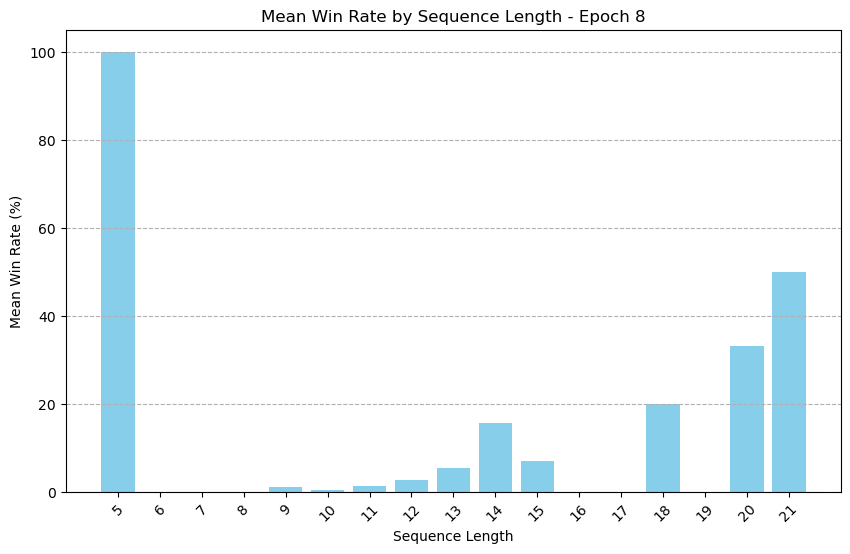

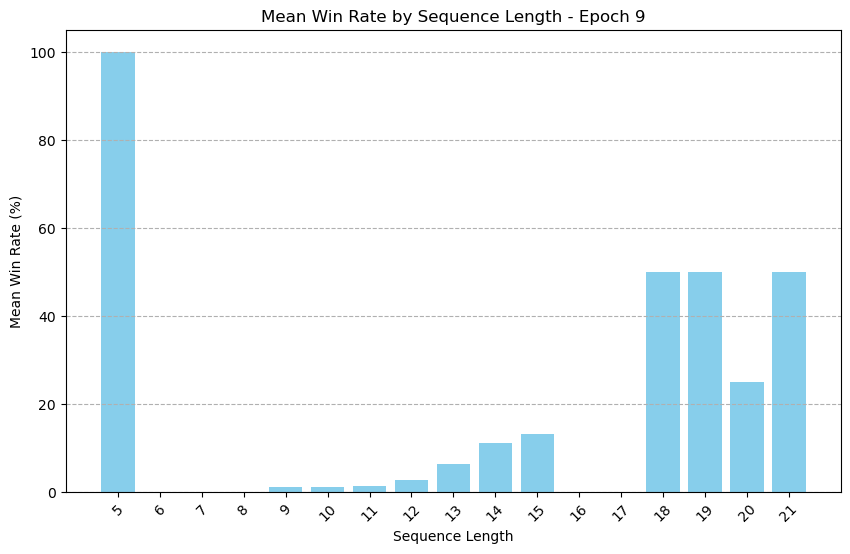

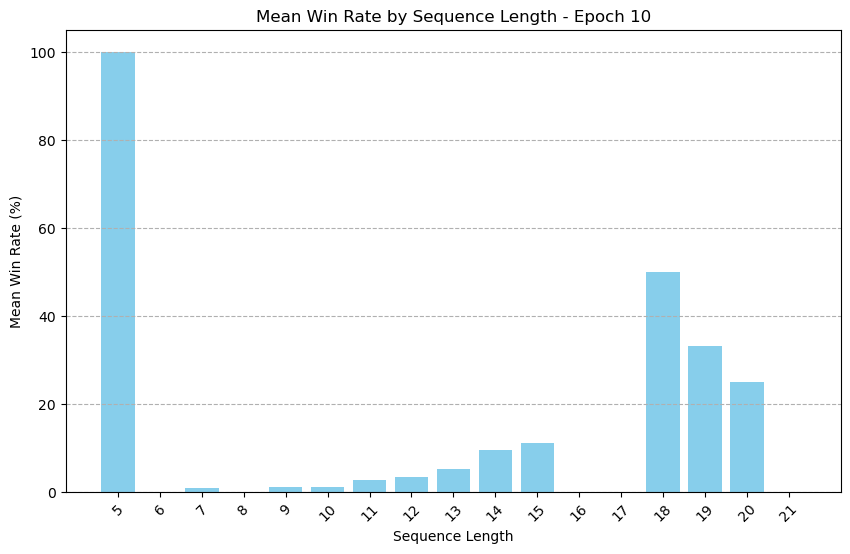

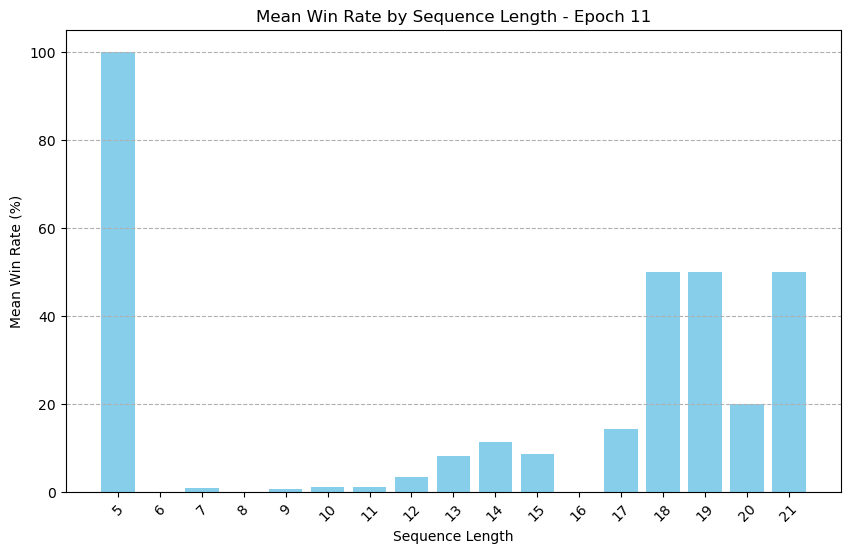

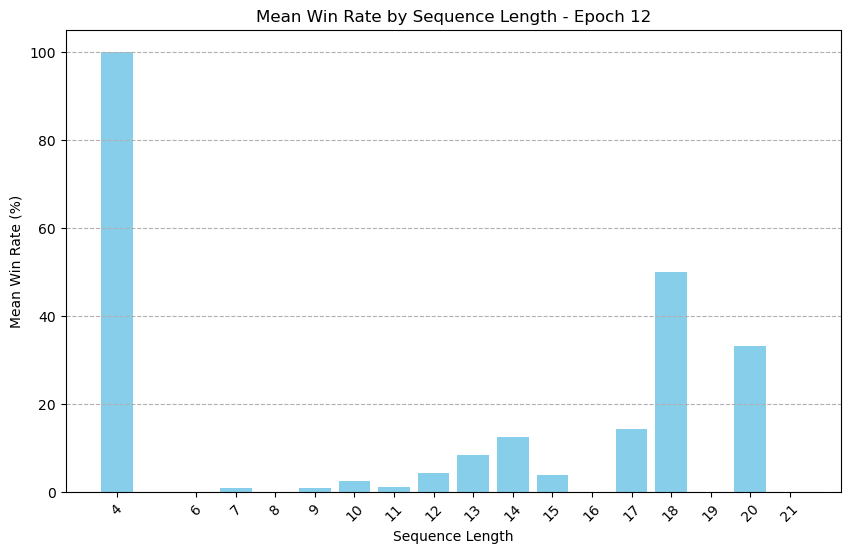

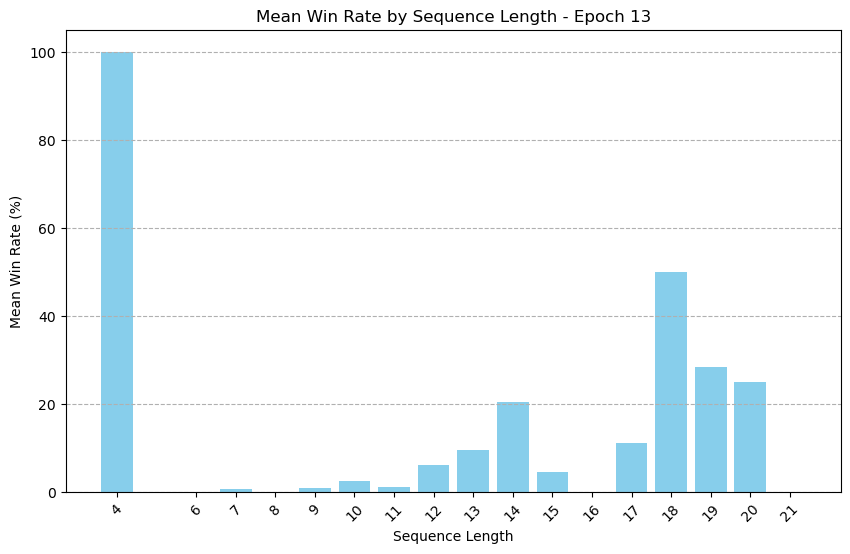

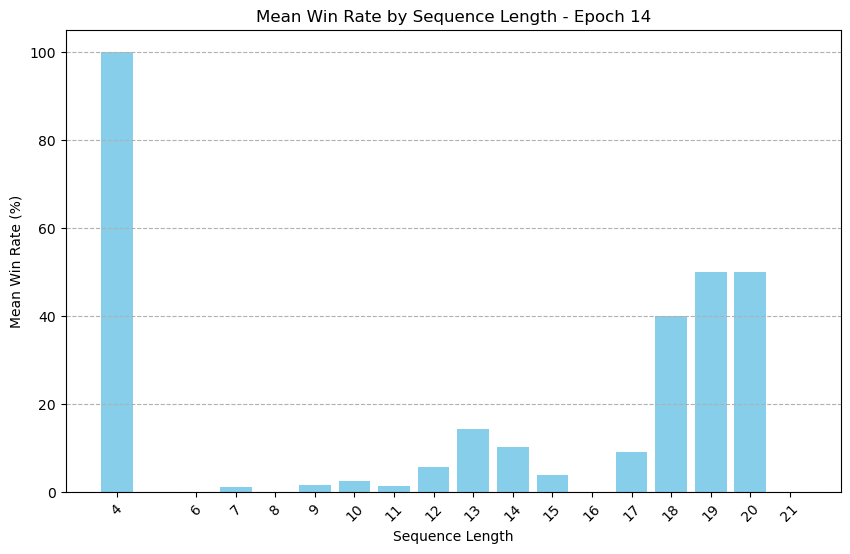

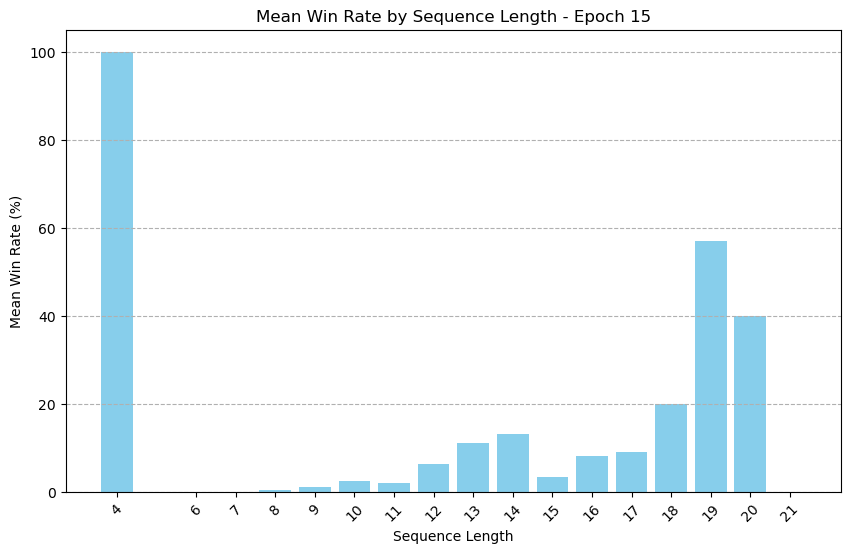

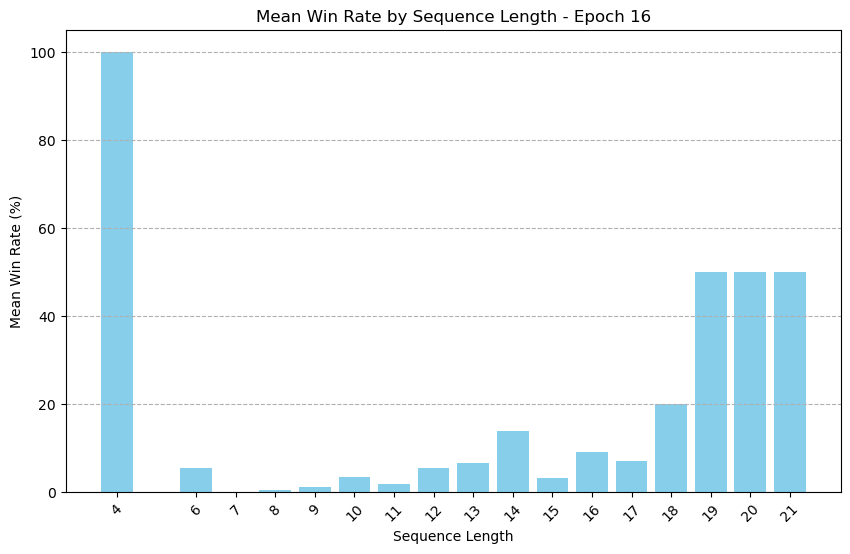

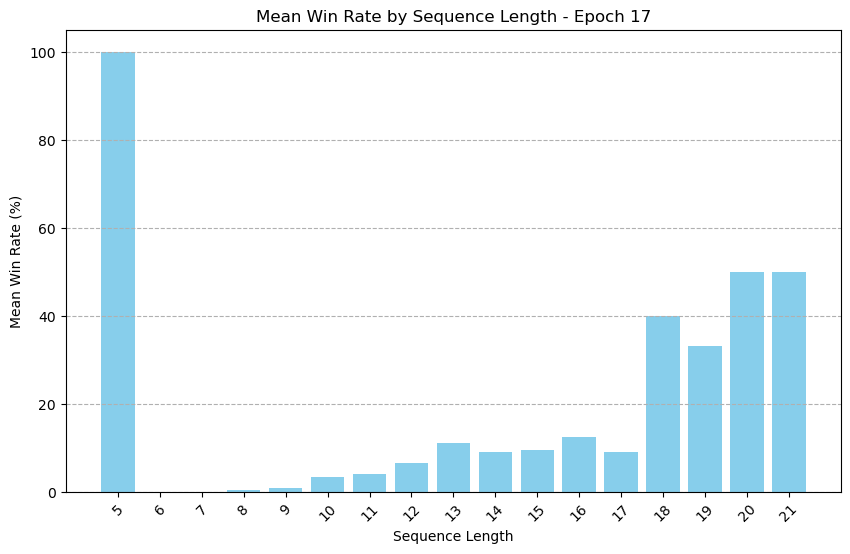

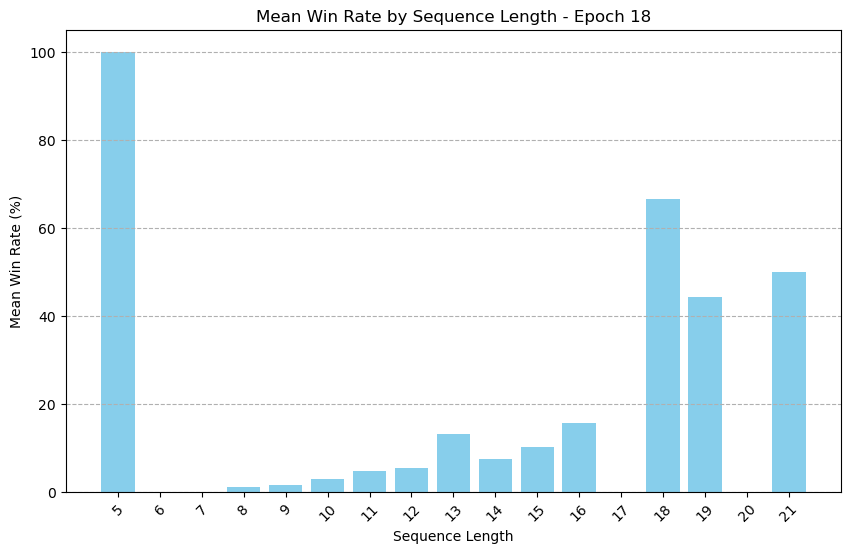

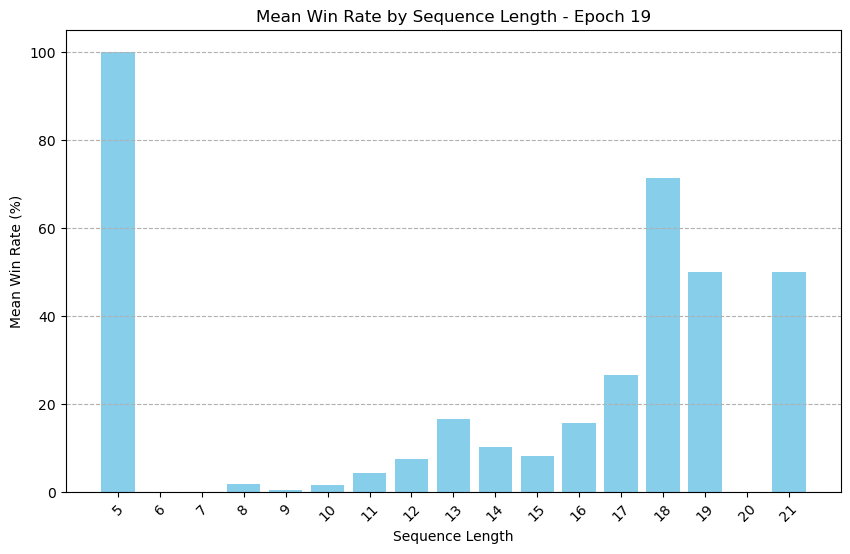

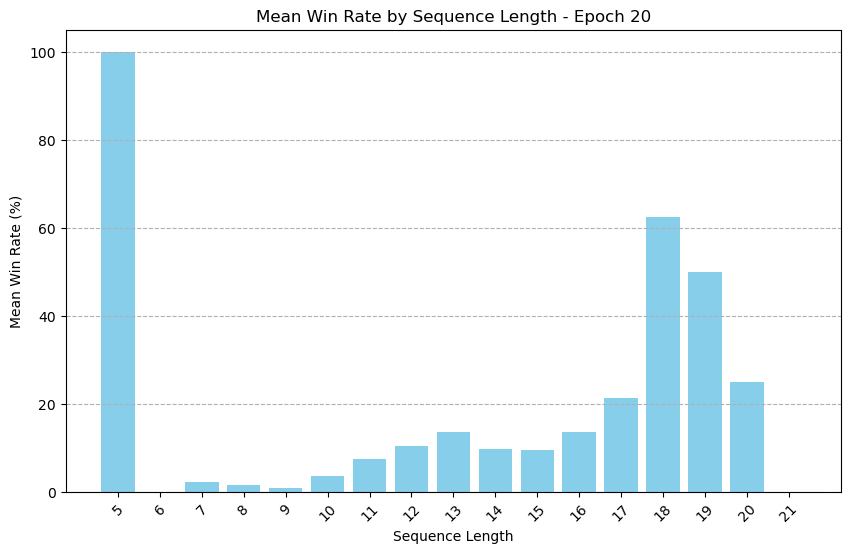

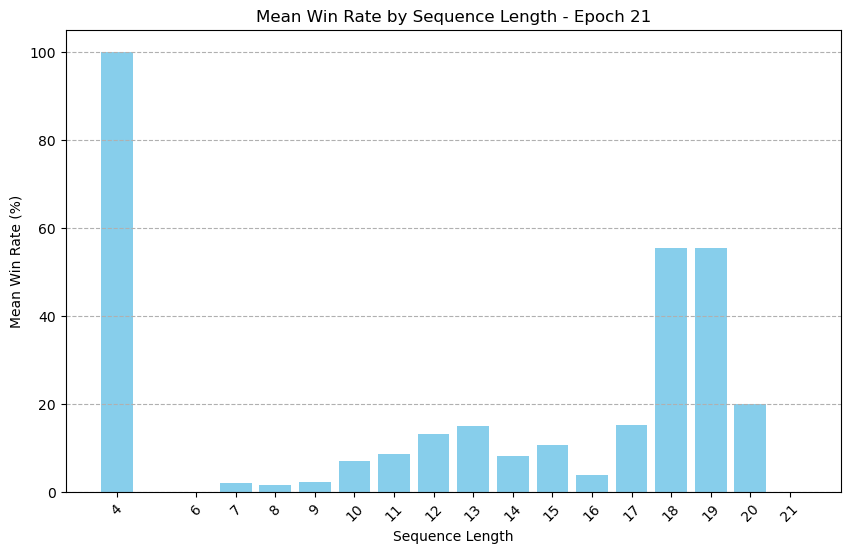

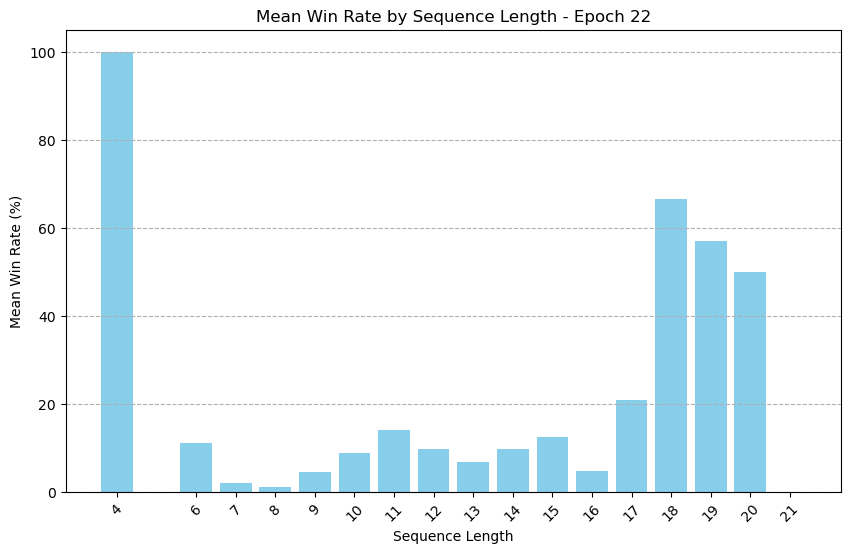

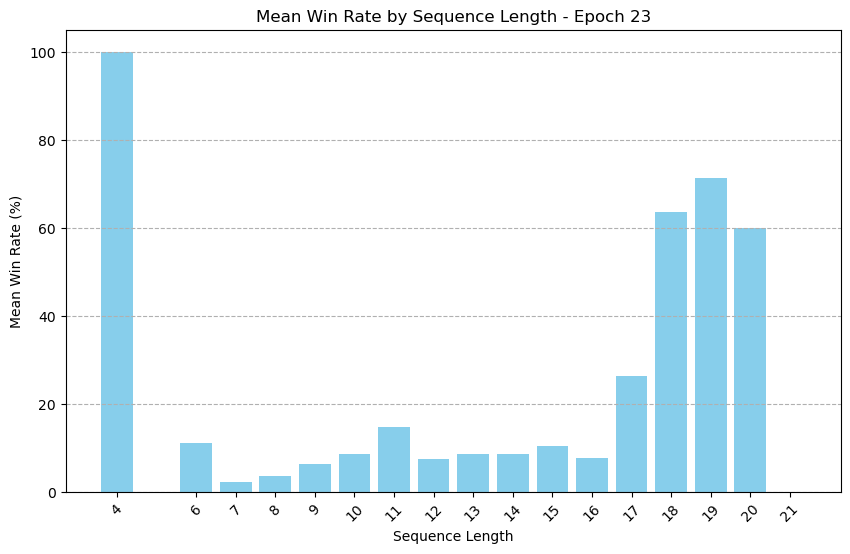

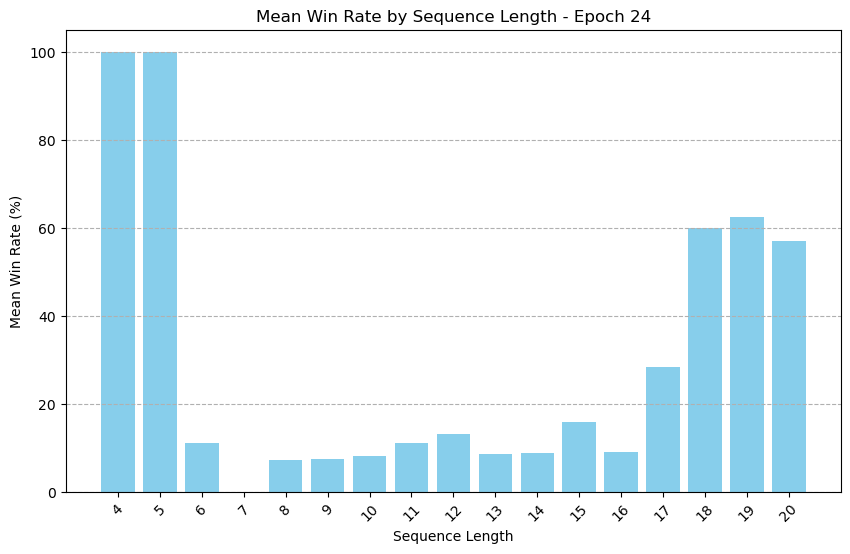

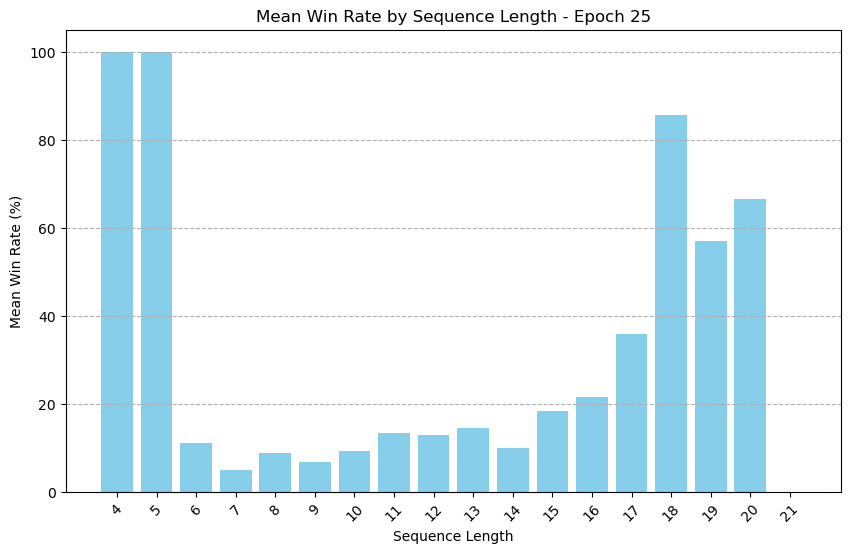

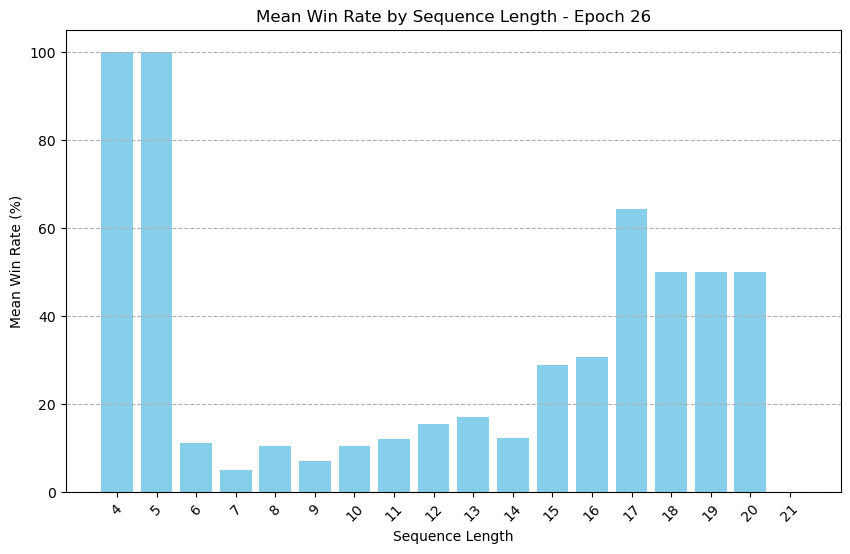

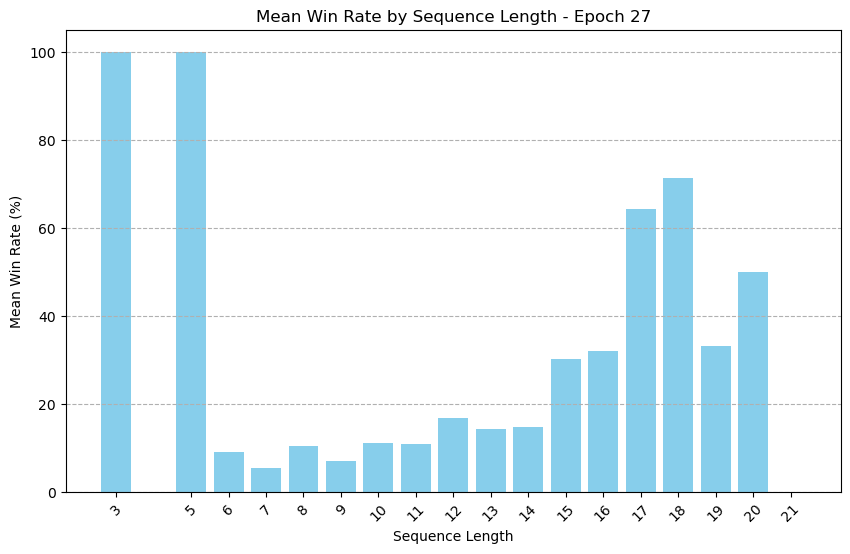

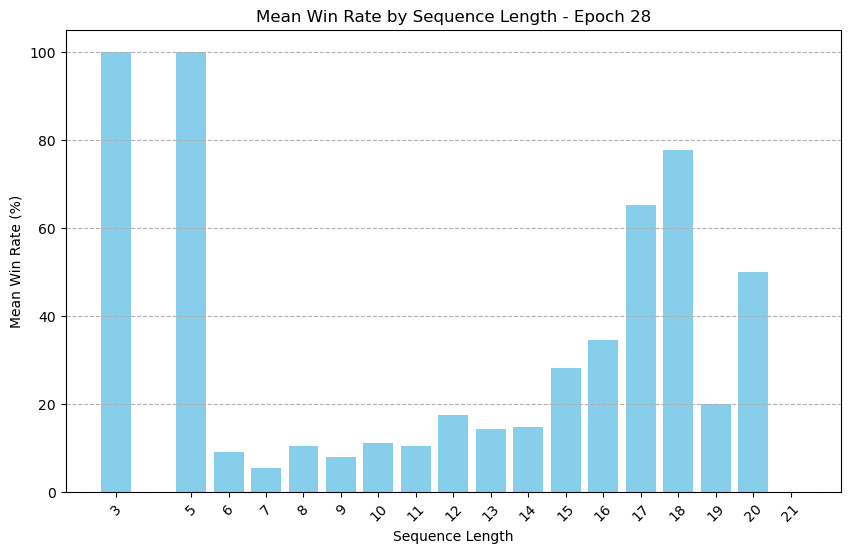

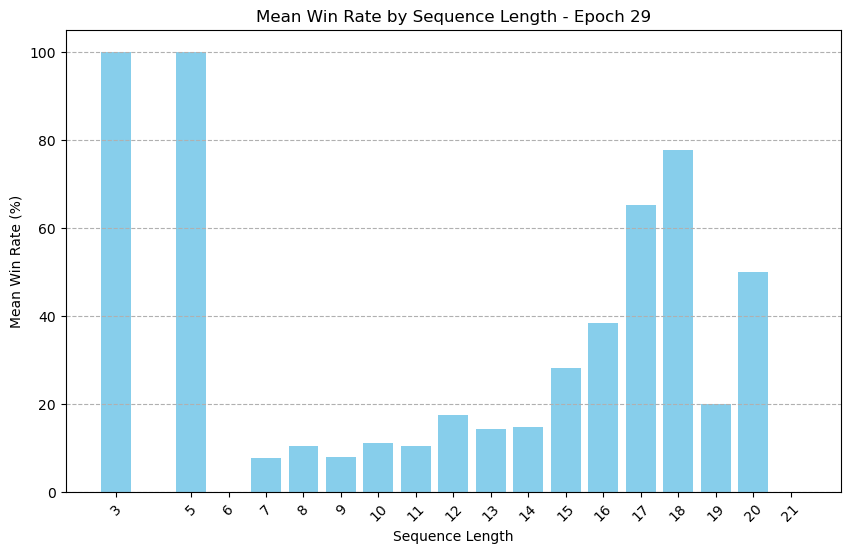

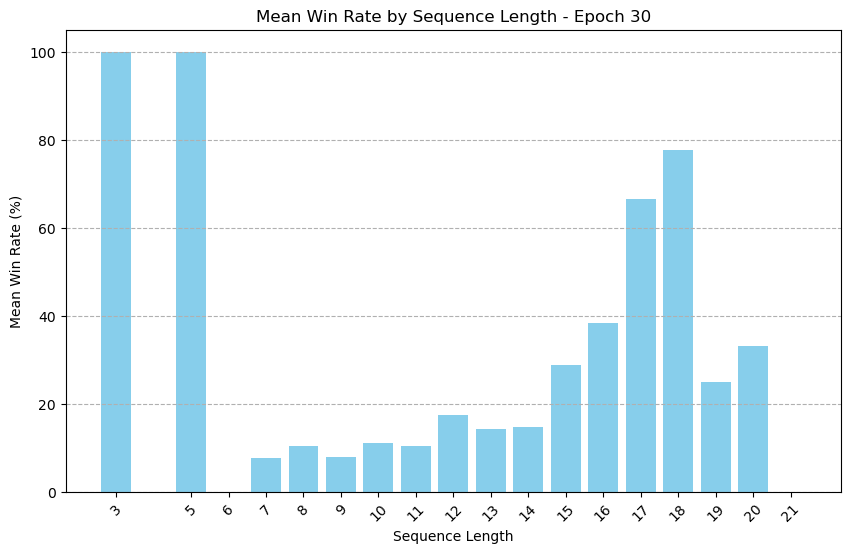

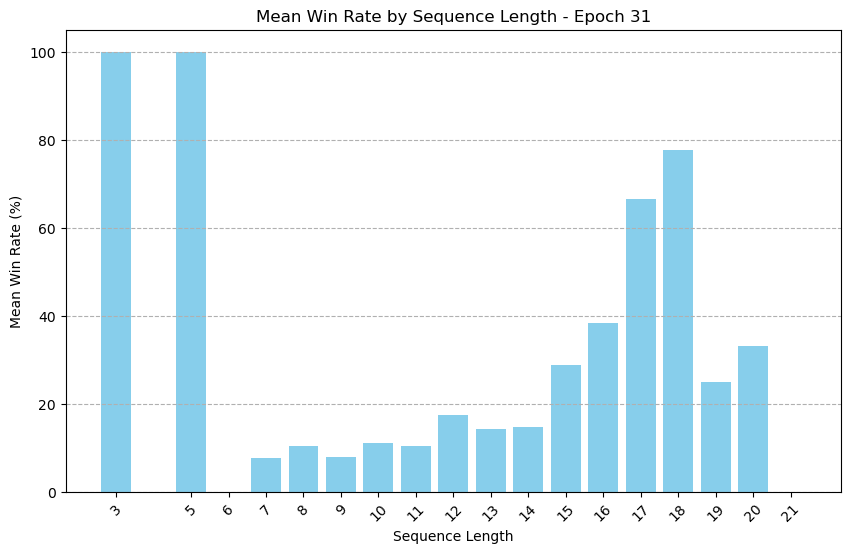

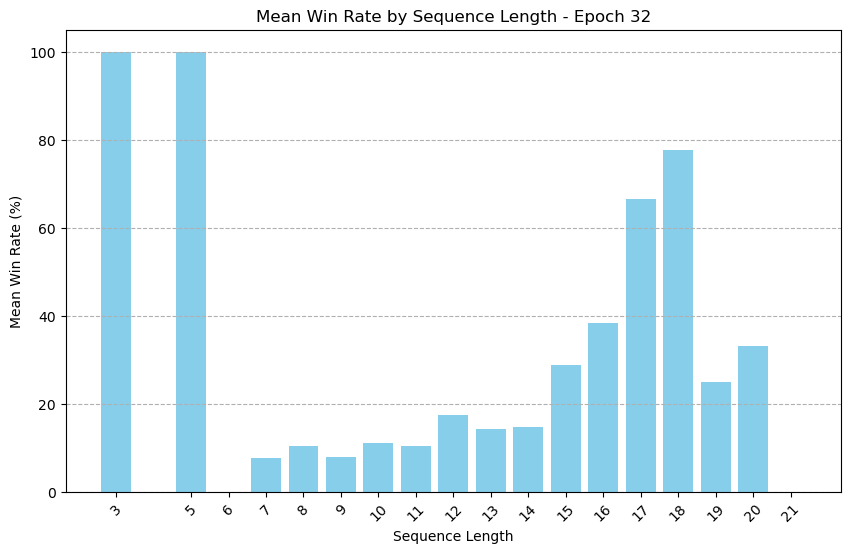

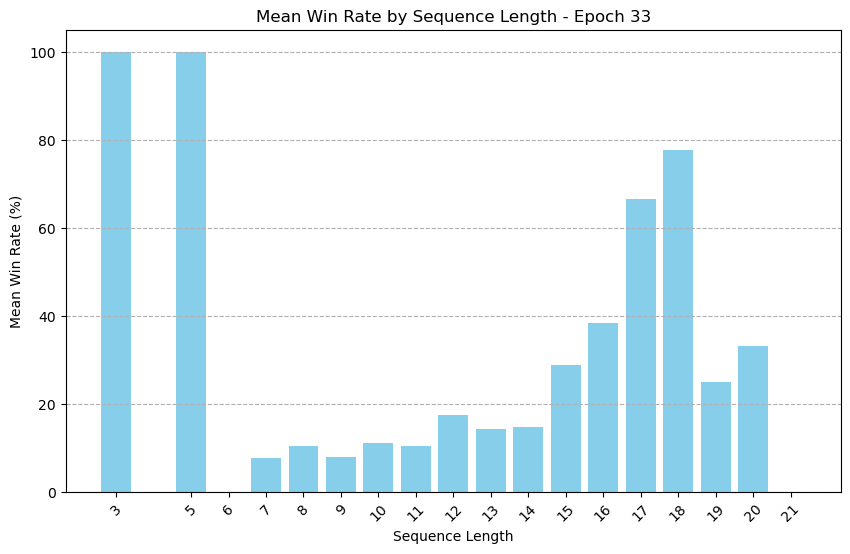

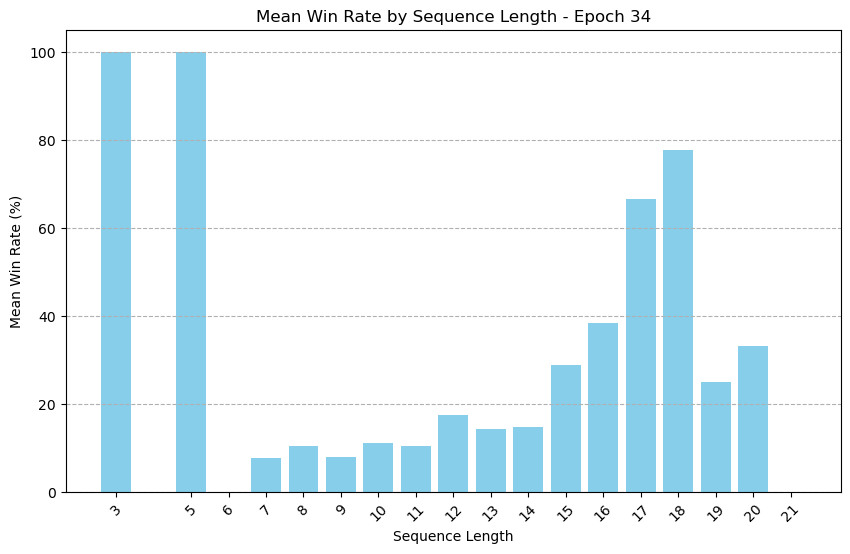

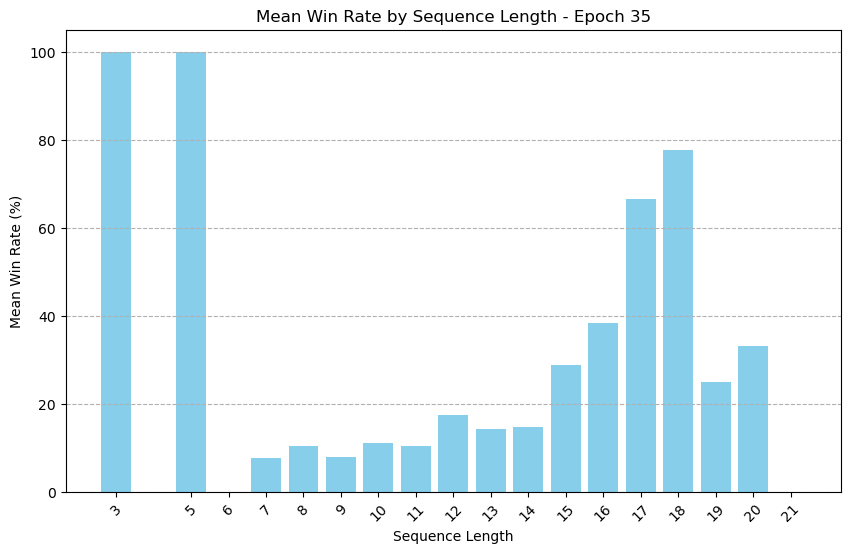

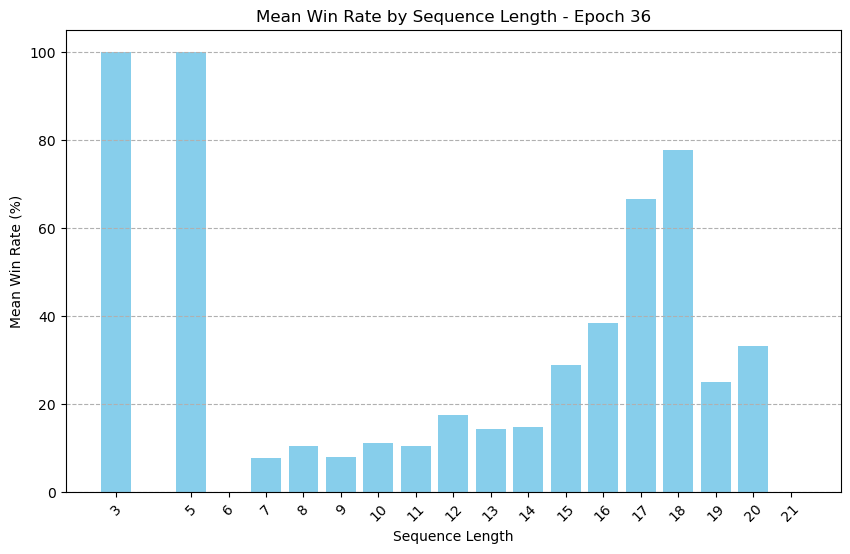

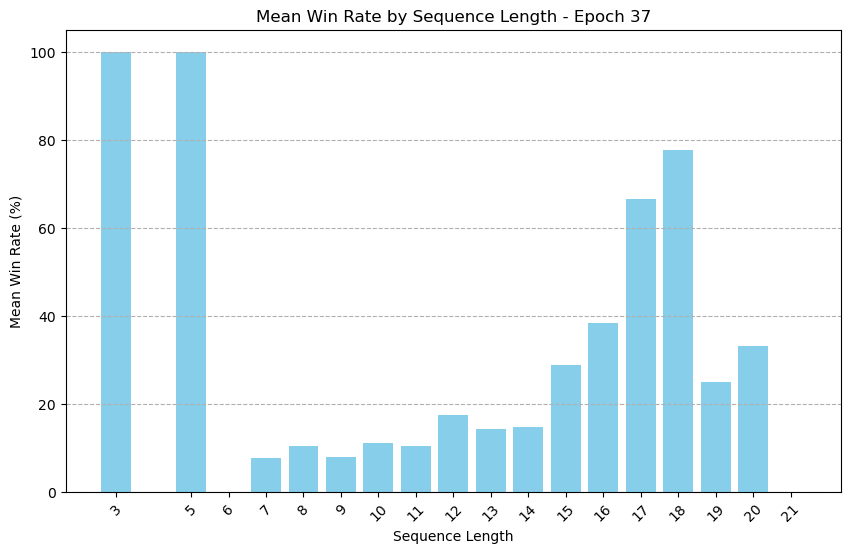

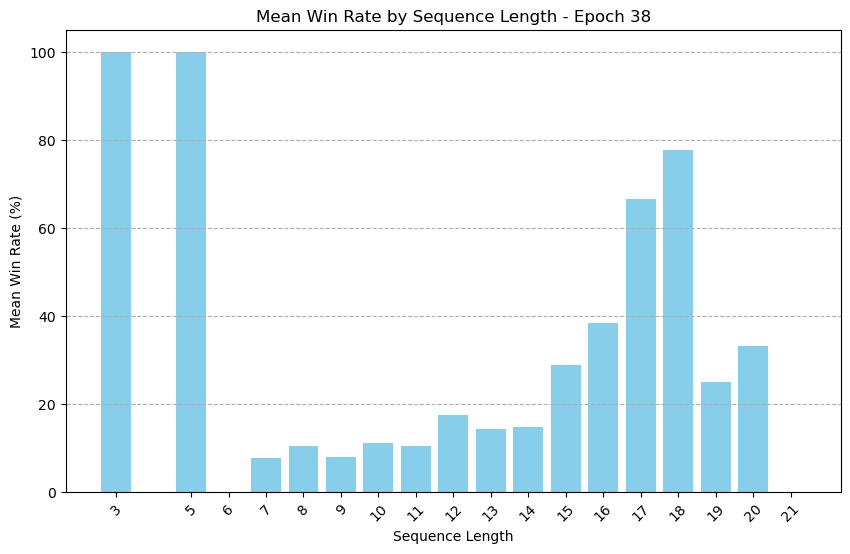

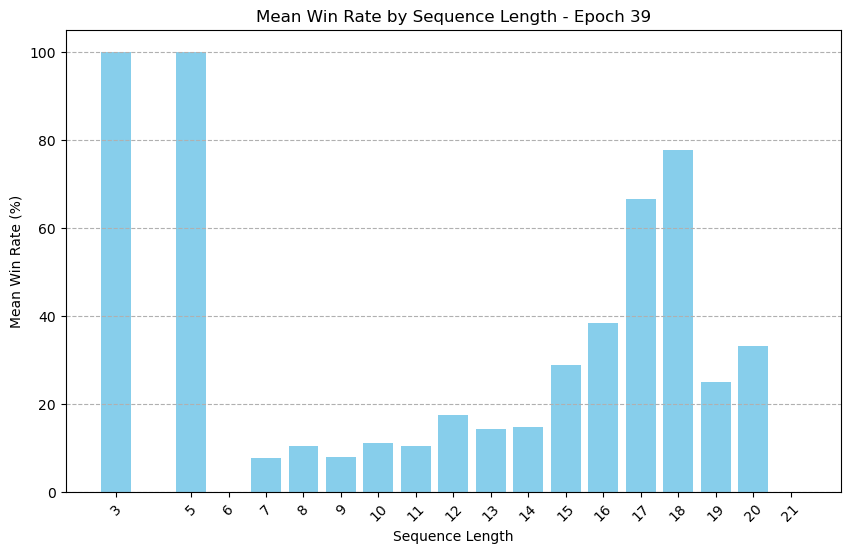

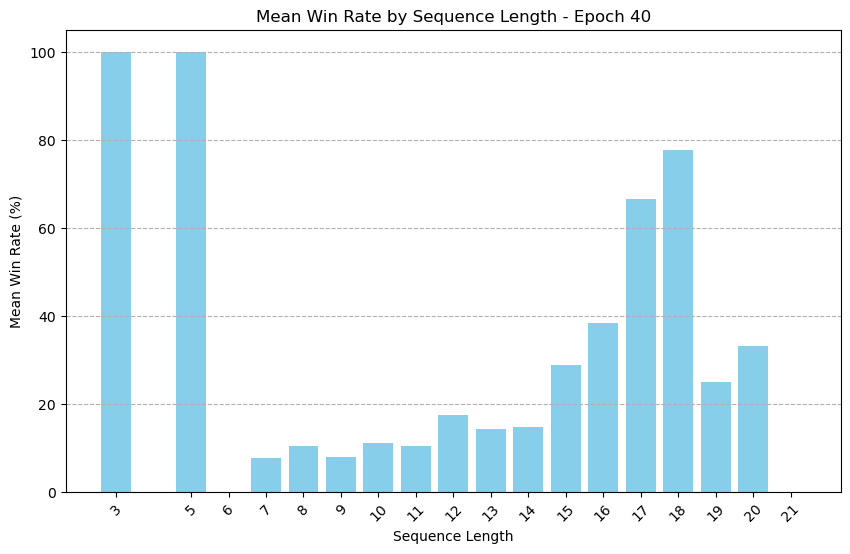

In [10]:
import optuna
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import shutil  # For directory cleanup

# Assuming necessary imports from your custom modules and PyTorch Lightning are done here

# Clear previous runs
base_dir = Path("/home/sayem/Desktop/Hangman")
checkpoints_dir = base_dir / "checkpoints"

# Clear out the old checkpoints and logs before starting a new run
if checkpoints_dir.exists():
    shutil.rmtree(checkpoints_dir)  # Remove the directory and all its contents

# Recreate the checkpoints directory after clearing it
checkpoints_dir.mkdir(parents=True, exist_ok=True)

# Now, create the tb_logs_dir inside the newly created checkpoints_dir
tb_logs_dir = checkpoints_dir / "tb_logs" / "HangmanModel"
tb_logs_dir.mkdir(parents=True, exist_ok=True)  # Ensure this directory is created after the checkpoints_dir


# Define a callback function for Optuna
def trial_callback(study, trial):
    # This function will be called at the end of each trial
    print(f"Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}.")
    print(f" Best trial so far: Trial {study.best_trial.number}")
    print(f" Best win rate so far: {study.best_trial.value}")

def objective(trial):
    # Hyperparameters to be tuned by Optuna
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512, 1024])
    hidden_dim = trial.suggest_categorical('hidden_dim', [16, 32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 5)
    embedding_dim = trial.suggest_categorical('embedding_dim', [20, 30, 40, 50])
    optimizer_type = trial.suggest_categorical('optimizer_type', ['Adam', 'AdamW', 'SGD', 'RMSprop'])
    dropout_prob = trial.suggest_float('dropout_prob', 0.0, 0.5)  # Suggesting dropout probability
    l1_factor = trial.suggest_float('l1_factor', 1e-5, 1e-1, log=True)  # Suggesting L1 regularization factor
    l2_factor = trial.suggest_float('l2_factor', 1e-5, 1e-1, log=True)  # Suggesting L2 regularization factor

    print(f"Starting trial with parameters:\n"
          f"  Learning Rate: {learning_rate}\n"
          f"  Batch Size: {batch_size}\n"
          f"  Hidden Dim: {hidden_dim}\n"
          f"  Num Layers: {num_layers}\n"
          f"  Embedding Dim: {embedding_dim}\n"
          f"  Optimizer Type: {optimizer_type}\n"
          f"  Dropout Prob: {dropout_prob}\n"
          f"  L1 Factor: {l1_factor}\n"
          f"  L2 Factor: {l2_factor}")  # Printing all tuned parameters

    # Update the batch size in the data module
    data_module.batch_size = batch_size

    # Re-instantiate the encoder and decoder with the new hyperparameters
    encoder = Encoder(num_embeddings, embedding_dim, max_word_length, char_feature_dim, additional_state_features)
    
    input_dim = max_word_length * embedding_dim + additional_state_features
    
    decoder = SimpleLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                        num_layers=num_layers, missed_char_dim=missed_char_dim, \
                        dropout_prob=dropout_prob)  # Using the dropout probability

    # Re-instantiate the model with the new encoder, decoder, learning rate, optimizer type, and regularization factors
    model = HangmanModel(encoder, decoder, learning_rate, char_frequency, max_word_length, 
                         optimizer_type=optimizer_type, l1_factor=l1_factor, l2_factor=l2_factor, 
                         test_words=sampled_test_words)

    # Set up PyTorch Lightning Trainer with Optuna integration
    logger = TensorBoardLogger(checkpoints_dir / "tb_logs", name="HangmanModel")
    
    checkpoint_callback = ModelCheckpoint(dirpath=checkpoints_dir, filename="best-checkpoint", 
                                          monitor="win_rate", mode="max", save_top_k=1)

    trainer = pl.Trainer(
        default_root_dir=checkpoints_dir,
        logger=logger,
        callbacks=[checkpoint_callback, early_stop_callback],
        max_epochs=MAX_EPOCH,
        log_every_n_steps=10,
        enable_progress_bar=True,
        fast_dev_run=False,
        num_sanity_val_steps=0,
        reload_dataloaders_every_n_epochs=1
    )

    # Fit the model
    trainer.fit(model, datamodule=data_module)

    # Return the best win rate recorded during training
    best_win_rate = checkpoint_callback.best_model_score.item() \
        if checkpoint_callback.best_model_score is not None else 0

    return best_win_rate

# Create an Optuna study with a name and optimize the objective function
study_name = f"NUM_STRATIFIED_SAMPLES_{NUM_STRATIFIED_SAMPLES}_HangmanModelTuning"

study = optuna.create_study(direction='maximize', study_name=study_name)
study.optimize(objective, n_trials=2, callbacks=[trial_callback])

# Output the best trial
best_trial = study.best_trial
print(f"Best trial: LR={best_trial.params['learning_rate']}, Batch Size={best_trial.params['batch_size']}")
print(f"Best win rate: {best_trial.value}")

# Save the study results for further analysis
# Construct the filename with the NUM_STRATIFIED_SAMPLES prefix
filename = f"NUM_STRATIFIED_SAMPLES_{NUM_STRATIFIED_SAMPLES}_optuna_study_results.csv"

# Save the study results to the specified file
study.trials_dataframe().to_csv(checkpoints_dir / filename)

# # Load the best model - This needs to be done after the study has concluded
# best_model_path = checkpoint_callback.best_model_path
# best_model = HangmanModel.load_from_checkpoint(checkpoint_path=best_model_path)

In [ ]:
STOP

In [ ]:
from pytorch_lightning.profilers import SimpleProfiler
import pytorch_lightning as pl
from scr.custom_callbacks import *
from scr.dataset import *
from scr.data_module import *
from scr.trainer_ import *

torch.cuda.empty_cache()

# # Create Callbacks
# loss_logging_callback = LossLoggingCallback()

# , SchedulerSetupCallback()] # , loss_logging_callback]
callbacks = [early_stop_callback, step_level_early_stopping] 
FAST_DEV_RUN = False
# # Calculate the minimum percentage of validation batches
# min_val_batches = 1 / len(data_module.val_dataloader())

# # Create Trainer with Callbacks
trainer = pl.Trainer(
    default_root_dir=output_dir,
    fast_dev_run=FAST_DEV_RUN, 
    max_epochs=MAX_EPOCH, 
    callbacks=callbacks,
    num_sanity_val_steps=0,
    reload_dataloaders_every_n_epochs=1,
    enable_progress_bar=True 
    # val_check_interval=0.5
    # limit_train_batches=2,  # Limit the number of training batches to 2
    # limit_val_batches=2     # Limit the number of validation batches to 2
)

# # # # # print(f"Running for {NUM_STRATIFIED_SAMPLES} samples...")
# # # print()
# # # # # # # Assuming combined_eval_metrics is a list of dictionaries
# combined_eval_metrics = trainer.validate(model=lightning_model, datamodule=data_module)

# # performance_metrics_dict = {k: v for d in combined_eval_metrics for k, v in d.items()}

# # # # # # print("Converted Performance Metrics Dictb ionary:", performance_metrics_dict)

# # trainer.datamodule.update_performance_metrics(combined_eval_metrics)

# data_module.update_performance_metrics(performance_metrics_dict)


# # Define the objective function for Optuna
# def objective(trial):
#     # Hyperparameters to be tuned by Optuna
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
#     batch_size = trial.suggest_categorical('batch_size', [128, 256, 512, 1024])
#     hidden_dim = trial.suggest_categorical('hidden_dim', [16, 32, 64, 128])
#     num_layers = trial.suggest_int('num_layers', 1, 5)
#     embedding_dim = trial.suggest_categorical('embedding_dim', [20, 30, 40, 50])

#     print(f"Starting trial with parameters:\n"
#         f"  Learning Rate: {learning_rate}\n"
#         f"  Batch Size: {batch_size}\n"
#         f"  Hidden Dim: {hidden_dim}\n"
#         f"  Num Layers: {num_layers}\n"
#         f"  Embedding Dim: {embedding_dim}")

#     # Update the batch size in the data module
#     data_module.batch_size = batch_size

#     # Re-instantiate the encoder and decoder with the new hyperparameters
#     encoder = Encoder(num_embeddings, embedding_dim, \
#         max_word_length, char_feature_dim, additional_state_features)

#     input_dim = max_word_length * embedding_dim + additional_state_features

#     decoder = SimpleLSTM(input_dim=input_dim, hidden_dim=hidden_dim, \
#             output_dim=output_dim, num_layers=num_layers, \
#             missed_char_dim=missed_char_dim)

#     # Re-instantiate the model with the new encoder, decoder, and learning rate
#     model = HangmanModel(encoder, decoder, learning_rate, char_frequency, \
#         max_word_length, test_words=sampled_test_words)

#     # Set up PyTorch Lightning Trainer with Optuna integration
#     logger = TensorBoardLogger(checkpoints_dir / "tb_logs", name="HangmanModel")
#     checkpoint_callback = ModelCheckpoint(dirpath=checkpoints_dir, \
#         filename="best-checkpoint", monitor="win_rate", mode="max", save_top_k=1)

#     trainer = pl.Trainer(
#         default_root_dir=checkpoints_dir,
#         logger=logger,
#         callbacks=[checkpoint_callback],
#         max_epochs=MAX_EPOCH,
#         log_every_n_steps=10,
#         enable_progress_bar=True,
#         fast_dev_run=False,
#         num_sanity_val_steps=0,
#         reload_dataloaders_every_n_epochs=1
#     )

#     # Fit the model
#     trainer.fit(model, datamodule=data_module)

#     # Return the best win rate recorded during training
#     best_win_rate = checkpoint_callback.best_model_score.item() \
#         if checkpoint_callback.best_model_score is not None else 0

#     return best_win_rate


##### Tuning: lr

In [ ]:
# from pytorch_lightning.tuner.tuning import Tuner

# # Assuming lightning_model, train_loader, and val_loader are already defined
# # Initialize the tuner with your trainer
# tuner = Tuner(trainer)

# # Run the learning rate finder using the data module
# lr_finder = tuner.lr_find(model=lightning_model, 
#                         datamodule=data_module)

# # Plot the learning rate finder results
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Get the suggested learning rate
# new_lr = lr_finder.suggestion()
# print(f"Suggested Learning Rate: {new_lr}")

# # Update model's learning rate
# lightning_model.learning_rate = 0.017378008287493765 # new_lr

# # Optionally, you can view the results of the LR finder
# print(lr_finder.results)

In [ ]:
# Update model's learning rate
lightning_model.learning_rate = 0.017378008287493765 # new_lr

##### Tuning: Batch

In [ ]:
# # Assuming lightning_model is already defined
# new_batch_size = tuner.scale_batch_size(
#     model=lightning_model,
#     datamodule=data_module,
#     mode='power',  # or 'binsearch'
#     steps_per_trial=10,
#     init_val=64,
#     max_trials=4
# )

# Update the batch size in the data module
data_module.batch_size = 1024 # new_batch_size

# print(f"Tune Batch size: ", new_batch_size)

##### Training

In [ ]:
# # # # # Validate the model (if needed)
# trainer.validate(model=lightning_model, datamodule=data_module)
print(f"Training Begin for {NUM_STRATIFIED_SAMPLES} words: {len(train_dataset)} Games")
# # # # # # Fit the model
trainer.fit(lightning_model, data_module)

# # Optionally print the profiler summary
# # print(profiler.summary())

# # Save the entire model
# trained_model_file = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
# torch.save(lightning_model, trained_model_file)
# print(f"Model saved at {trained_model_file}")

In [ ]:
# Save the entire model
trained_model_file = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
torch.save(lightning_model, trained_model_file)
print(f"Model saved at {trained_model_file}")

##### Testing

In [ ]:
# Finding the maximum word length in the list
max_word_length_in_list = max(len(word) for word in sampled_test_words)

max_word_length_in_list

In [ ]:
# # Load the entire LSTM model object
# untrained_model_file_path = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"

untrained_model = torch.load(untrained_model_file)

# Example usage
result = play_games_and_calculate_stats(untrained_model, \
    sampled_test_words, char_frequency, max_word_length)

print(f"Untrained model performence: {result['overall_win_rate']} % win rate")

performance_metrics = result['length_wise_stats']

# print(performance_metrics)

from scr.utils import *

plot_hangman_stats(performance_metrics)

for length, data in result["length_wise_stats"].items():
    print(f"Length {length}: Win Rate: {data['win_rate']}%, Average Attempts: {data['average_attempts_used']}")

In [ ]:
# trained_model_file_path = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
# trained_model = torch.load(trained_model_file_path)
# print(type(trained_model))

In [ ]:
# # Load the entire LSTM model object

# trained_model_file_path = models_dir / f"{NUM_STRATIFIED_SAMPLES}_trained_model.pth"
# trained_model = torch.load(trained_model_file_path)

# # # If you want to use the model for inference
# # trained_model.eval()  # Set the model to evaluation mode

# from scr.game import *

# word = 'may'

# play_game_with_a_word(trained_model, \
#     word, char_frequency, max_word_length)

In [ ]:
# # Example usage
# result = play_games_and_calculate_stats(trained_model, \
#     sampled_test_words, char_frequency, max_word_length)

# print(f"Overall Win Rate: {result['overall_win_rate']}%, Overall Average Attempts: {result['overall_avg_attempts']}")

# # for length, data in result["length_wise_stats"].items():
# #     print(f"Length {length}: Win Rate: {data['win_rate']}%, Average Attempts: {data['average_attempts_used']}")

In [ ]:
performance_metrics = result['length_wise_stats']

plot_hangman_stats(performance_metrics)

In [ ]:
performance_metrics